In [1]:
# Notebook: BookRecommender-Slim
# Author: George Tohme
# Date: Sep 27, 2018

### Approach
This notebook outlines my attempts at tackling the book recommendation problem. 

At a high level, since we don't have actual ratings of books by users but rather the interaction with the books, I opted to treat the 6 types of interactions as scaled up rating imitating regulr 1-5 star ratings with an interaction of 'dislike getting rated as a '0', all the way to an interaction of 'checkout' being rated as as a '5'.

Anther potential approach would be to treat this problem as a classification problem. I have not attempted to do so.

As you can see below, I have taken a couple of paths to the solution:
1. Considering the problem production-related constraints, I attemted using a simple **Matrix Factorization** method using standard libraries and functions namely **scipy.sparse.linalg's SVDS**. This a simple collaborative filtering exercise where we know some of the ratings (in our case, pseudo-ratings) and we're trying to uncover latent features. The big question here is determining the 'k' factor. As noted in the code below, I have not attempted to optimize the algorithm to find an optimal 'k'.

2. Having worked on a similar problems using **Neural Net** (using the **Keras** library with **Tensorflow** as the backend) with pretty reasonable performance, I attempted to apply that approach to this problem by providing multiple models including a simple NNMF.

  
With the exception of one NN, I have not used any explicite data features. One NN model, I complemented the latent features with the inclusion of the books' **Author and YearOfPublication**.

In a real-life scenario, we're always be faced with the problem of providing recommendations to new users to avoid the 'cold start problem'. This could be mitigated using a number of methods from beefing up the user profile with preferences to finding recommendations based on similar users, best sellers, new books, etc...

#### Results
The results were a mixed bag. 

Why? Generally, one should start with looking at the data, the approach and then the algorithms/models.

In the case of the NN models, overfitting seemed to be a problem across the different model architecture.

I think the data (and its sparcity) played a huge role. Taking the same models and applying them to similiar-ish data such as the MovieLens dataset would yield a more consistent results. So that could mean that the data is odd is some to-be-determined way or the approach (treating the interactions as ratings) is not a good one.

It also could be that the model parameters need further tuning or simply that there is something wrong with code. In both case, more time for further investigation could yield better results.

The best result (although the numbers look very suspicious) was obtained using Model 0 (SVD) with a resulting predictions table shape (17252, 21128) which will create a massibe multi-GB file.

### General notes
As noted above, the results are a mixed bag which could attributed to one or many reasons:
- limited time for testing and finetuning
- available processing power 
- data quality & consistency

Throughout, I attempted to simulate a clean-data environment. To that end, I limited my dataset to a normalized subset (from the events.csv) satisfying the following 2 conditions:
- the books must exist in the books.csv
- the users must exist in the users.csv

I could blame lack of time for a number of things that could and should have been better with the code below, but in all honesty i only had about a day to work on this. This is not the most elegant code: inefficient use of memeory (lots of pd dataframes), df joinging/merging is a bit convoluted. However, I thouroughly enjoyed it.


In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from scipy.sparse.linalg import svds
from scipy import linalg

from math import sqrt

from IPython.display import SVG, display, HTML
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import pydot

import keras

from keras.models import Model
from keras.layers import Input, Embedding
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.merge import dot, add, concatenate

from keras.regularizers import l2
from keras.optimizers import Adam, SGD
from keras.constraints import non_neg

/anaconda3/envs/keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [60]:
# Constants

SVD_k = 150
MAX_RECOMMENDATIONS = 10

MM_LATENT_FACTORS = 5
MM_BATCH_SIZE = 64
MM_TRAIN_EPOCHS = 50

TRAIN_VERBOSE = 1
TRAIN_SPLIT_RATIO = 0.2

NN_USER_LATENT_FACTORS = 150
NN_MOVIE_LATENT_FACTORS = 150
NN_TRAIN_EPOCHS = 50
NN_BATCH_SIZE = 500

# Non-negative Matrix factorisation
NNMF = True

SGD_OPTIMIZER = False

# Adam Parameters
Adam_lr=0.02
Adam_beta_1=0.9
Adam_beta_2=0.999
Adam_epsilon=None
Adam_decay=0.0
Adam_amsgrad=False

#SGD Parameters
SGD_lr=0.02
SGD_momentum=0.0
SGD_decay=0.0
SGD_nesterov=False

In [4]:
# Translate the events action to ratings. 
# That's the approach taken in this Notebook.

# Another idea is to one-hot encode the actions and then 
# treat the problem as a classification problem. 
# Have not tried this to see if it yields better predictions.

impressionRatings = {
  "dislike" : 0,
  "view" : 1,
  "interact" : 2,
  "like" : 3,
  "add to cart" : 4,
  "checkout" : 5
}

In [5]:
# A function to display tables & plots side-by-side

from IPython.display import display_html
def displaySideBySide(*args):
    htmlStr=''
    for df in args:
        htmlStr += df.to_html()
    display_html(htmlStr.replace('table','table style="display:inline"'), raw=True)
#enddef

#### Read and show the data...

In [6]:
usersDataFrame = pd.read_csv('../Data/Users.csv', encoding = 'latin-1')
booksDataFrame = pd.read_csv('../Data/Books.csv', encoding = 'latin-1')
eventsDataFrame = pd.read_csv('../Data/UserEvents.csv', encoding = 'latin-1')

In [7]:
# Preliminary dimensions
len(usersDataFrame.index), len(booksDataFrame.index), len(eventsDataFrame.index)

(100000, 149998, 400000)

In [8]:
usersDataFrame.head()

,Unnamed: 0,user,location,age
0,177121,177122.0,"winter park, florida, usa",50.0
1,174021,174022.0,"fairview park, ohio, usa",NaN
2,179441,179442.0,"farmville, north carolina, usa",45.0
3,44391,44392.0,"weston, florida, usa",65.0
4,89250,89251.0,"duesseldorf, n/a, germany",NaN


In [9]:
booksDataFrame.head()

,Unnamed: 0,bookISBN,bookName,author,yearOfPublication,publisher,urlId
0,58005,773730982,"Stretch, Swallow &amp; Stare",Veronika Martenova Charles,1999,Stoddart Kids,8040.0
1,158211,916620867,The Two Faces of Religion: A Psychiatrists View,N.S. Xavier,1987,Portals Pr,46584.0
2,127812,380978598,Roma Eterna,Robert Silverberg,2003,Eos,39681.0
3,47598,802727719,For Everything a Season: Simple Musings on Liv...,Philip Gulley,2001,Walker Large Print,29478.0
4,131723,446604178,"Mountain, Get Out of My Way: Life Lessons and ...",Montel Williams,1997,Warner Books (Mm),104573.0


In [10]:
eventsDataFrame.head()

,Unnamed: 0,user,bookId,impression
0,523113,126736,0843946806,dislike
1,861298,208406,0345353145,like
2,37104,8890,2020213508,add to cart
3,328497,78553,0451402383,add to cart
4,121368,27875,0307129659,add to cart


In [11]:
eventsDataFrame.shape

(400000, 4)

#### Preliminary cleanup...

In [12]:
# Rename the user column for consistency
usersDataFrame.rename(columns={"user": "userId"}, inplace = True)

In [13]:
# Rename the bookId column for consistency
booksDataFrame.rename(columns={"bookId": "bookISBN"}, inplace = True)

In [14]:
# Some housekeeping column names updates for consistency and clarity...
eventsDataFrame.rename(columns={"user": "userId"}, inplace = True)
eventsDataFrame.rename(columns={"bookId": "bookISBN"}, inplace = True)

In [15]:
# Convert the impression to a rating (think sales funnel ratings)
eventsDataFrame["impressionRating"] = eventsDataFrame["impression"].map(impressionRatings)

In [16]:
# Remove the old text impression columns and the first column (event row id)
eventsDataFrame.drop(eventsDataFrame.columns[0], axis=1, inplace=True)
eventsDataFrame.drop(eventsDataFrame.columns[2], axis=1, inplace=True)

#### Merge the dataframes and remove the nulls...

In [17]:
# Join the events DF to the books DF using the books' ISBN.
# We're doing this, to ensure we're counting the books and users 
# that exist in the other tables (files)

# Building the unique indices based on the full events file will 
# yield incorrect data and will cause the models to crash as some ids will 
# larger than what max count is.

filledEventsDataFrame = pd.merge(eventsDataFrame,
             booksDataFrame[['author', 'yearOfPublication', 'bookISBN']], 
             on='bookISBN', 
             how='inner')

In [18]:
# Remove all nulls...
filledEventsDataFrame = filledEventsDataFrame.dropna()

#### Create unique ids for come columns...

In [19]:
# Build an index for the books' authors' names
authors = filledEventsDataFrame['author'].unique()
authorsDict = {name: authorId for authorId, name in enumerate(authors)}

# add it to the books dataframe
booksDataFrame["authorIDX"] = booksDataFrame["author"].map(authorsDict)
# and to ....
filledEventsDataFrame["authorIDX"] = filledEventsDataFrame["author"].map(authorsDict)

In [20]:
# Create a book id based on the users in the events dataset
bookIds = filledEventsDataFrame["bookISBN"].unique()
bookIdsDict = {bookId: bookIDX for bookIDX, bookId in enumerate(bookIds)}

# add it to the books dataframe
booksDataFrame["bookIDX"] = booksDataFrame["bookISBN"].map(bookIdsDict)

# and to ...
filledEventsDataFrame["bookIDX"] = filledEventsDataFrame["bookISBN"].map(bookIdsDict)

In [21]:
# Create a unique user id based on the users in the events dataset
userIds = filledEventsDataFrame["userId"].unique()
userIdsDict = {userId: userIDX for userIDX, userId in enumerate(userIds)}

# Add it to the users dataframe
usersDataFrame["userIDX"] = usersDataFrame["userId"].map(userIdsDict)

# and to ...
filledEventsDataFrame["userIDX"] = filledEventsDataFrame["userId"].map(userIdsDict)

In [22]:
filledEventsDataFrame.head()

,userId,bookISBN,impressionRating,author,yearOfPublication,authorIDX,bookIDX,userIDX
0,850,3426616262,2,Alexander Solschenizyn,1999,0,0,0
1,177458,1565112318,2,Neil Gaiman,1997,1,1,1
2,151420,8445071416,4,J. R. R. Tolkien,1991,2,2,2
3,229501,8445071416,3,J. R. R. Tolkien,1991,2,2,3
4,93755,8445071416,4,J. R. R. Tolkien,1991,2,2,4


In [23]:
filledEventsDataFrame.shape

(41048, 8)

#### Ensure there are no nulls in the dataframe we will be using and save it (just in case) for offline inspection...

In [24]:
filledEventsDataFrame[filledEventsDataFrame.isnull().any(axis=1)]

,userId,bookISBN,impressionRating,author,yearOfPublication,authorIDX,bookIDX,userIDX


In [25]:
filledEventsDataFrame.to_csv("filledEventsDataFrame.csv")

#### Split the data into training and test sets...

In [26]:
# Do the split...
trainDataFrame, testDataFrame = train_test_split(filledEventsDataFrame, test_size=TRAIN_SPLIT_RATIO)

# Grab the actual impression to check the results later
actualImpressionRatings = testDataFrame["impressionRating"]

In [27]:
# dig into the data...
numOfUsers = len(filledEventsDataFrame['userIDX'].unique())
numOfBooks = len(filledEventsDataFrame['bookIDX'].unique())
dataSparcity = 100.0 - (100.0 * len(filledEventsDataFrame) / (numOfUsers * numOfBooks))

print(filledEventsDataFrame.shape)
print("Number of users: " + str(numOfUsers))
print("Number of books: " + str(numOfBooks))
print("Matrix sparcity: {0:2.4f}%".format(dataSparcity))

(41048, 8)
Number of users: 17252
Number of books: 21128
Matrix sparcity: 99.9887%


#### Show a crosstab of the data...

In [28]:
# Inspect the crosstab of the top users/books events (ratings)

g = filledEventsDataFrame.groupby('userIDX')['impressionRating'].count()
topUsers = g.sort_values(ascending=False)[:20]

g = filledEventsDataFrame.groupby('bookIDX')['impressionRating'].count()
topBooks = g.sort_values(ascending=False)[:20]

topRatings = filledEventsDataFrame.join(topUsers, how='inner', rsuffix='r_', on='userIDX')
topRatings = topRatings.join(topBooks, how='inner', rsuffix='r_', on='bookIDX')

pd.crosstab(topRatings.userIDX, topRatings.bookIDX, topRatings.impressionRating, aggfunc=np.sum)

bookIDX,30,34,41,46,60,63,87,156,171,206,292,420,472,518,774,869
userIDX,,,,,,,,,,,,,,,,
21,3.0,NaN,0.0,4.0,5.0,1.0,5.0,NaN,NaN,5.0,NaN,3.0,3.0,NaN,5.0,5.0
107,4.0,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
414,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
520,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1156,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,5.0,NaN,NaN,5.0,NaN,NaN,4.0,5.0
1244,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,1.0,NaN,NaN
1348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0


#### Show the heads...

In [29]:
trainDataFrame.head()

,userId,bookISBN,impressionRating,author,yearOfPublication,authorIDX,bookIDX,userIDX
30466,49900,1551667290,2,Candace Camp,2003,1229,11340,4393
14082,80908,8440673582,3,John Varley,1999,2218,2707,1610
35813,116703,031225220X,5,Susan Sussman,2000,10749,15426,15681
34785,75339,3442726875,3,Patrick McGrath,2000,8947,14589,10459
6558,146175,042513525X,3,Dean R. Koontz,1992,682,745,4860


In [30]:
trainDataFrame.shape

(32838, 8)

In [31]:
testDataFrame.head()

,userId,bookISBN,impressionRating,author,yearOfPublication,authorIDX,bookIDX,userIDX
23332,266465,1930502028,5,Doc Robertson,2001,5169,6837,12068
20290,48982,8838917299,2,Andrea Camilleri,0,651,5281,11038
13599,183046,1853262013,2,G. Grossmith,1999,2128,2582,3689
13049,142474,3499227002,1,Hellmuth Karasek,2000,2002,2399,8088
36508,128208,1887655816,4,Criswell Freeman,1997,4412,16008,8076


In [32]:
testDataFrame.shape

(8210, 8)

In [33]:
actualImpressionRatings.head()

23332    5
20290    2
13599    2
13049    1
36508    4
Name: impressionRating, dtype: int64

In [34]:
actualImpressionRatings.shape

(8210,)

In [35]:
filledEventsDataFrame.head()

,userId,bookISBN,impressionRating,author,yearOfPublication,authorIDX,bookIDX,userIDX
0,850,3426616262,2,Alexander Solschenizyn,1999,0,0,0
1,177458,1565112318,2,Neil Gaiman,1997,1,1,1
2,151420,8445071416,4,J. R. R. Tolkien,1991,2,2,2
3,229501,8445071416,3,J. R. R. Tolkien,1991,2,2,3
4,93755,8445071416,4,J. R. R. Tolkien,1991,2,2,4


# The models

#### ---------Model 0: Matrix Multiplication - SVD Implementation (No Optimization)--------------

In [36]:
# Build the full ratings dataframe
R_DataFrame = filledEventsDataFrame.pivot(index = 'userIDX', 
                                          columns ='bookIDX', 
                                          values = 'impressionRating').fillna(0)

In [37]:
R_DataFrame.shape

(17252, 21128)

In [38]:
# Convert it to a matrix (array)
R_Matrix = R_DataFrame.values

In [39]:
meanUserRatings = np.mean(R_Matrix, axis = 1)

In [40]:
R_Demeaned = R_Matrix - meanUserRatings.reshape(-1, 1)

In [41]:
# TODO: Optimize  'k'

# Ideally, we could optimize svds by creating a training and validation set to find the best 'k'
# by automatically minimizing the resulting RMSE.

In [42]:
# TODO: Assess adding a bias

In [43]:
# In the interest of time, this is not done here. Instead, I checked the outside temperature and
# I picked k=150

In [53]:
# Crunch and factorize by calling on scipy...
U, sigma, Vt = svds(R_Demeaned, k=SVD_k)

In [54]:
# Convert sigma into a diag matrix to be used for predictions
sigma = np.diag(sigma)

In [55]:
# Recreate the ratings by multiplying the 3 matrices...
allPredictedRatings = np.dot(np.dot(U, sigma), Vt) + meanUserRatings.reshape(-1, 1)

In [56]:
# Format into a dataframe and add column names
allPredictedRatingsDataFrame = pd.DataFrame(allPredictedRatings, columns = R_DataFrame.columns)
allPredictedRatingsDataFrame.shape

(17252, 21128)

In [57]:
allPredictedRatingsDataFrame.round(decimals=4).head(100)

bookIDX,0,1,2,3,4,5,6,7,8,9,...,21118,21119,21120,21121,21122,21123,21124,21125,21126,21127
0,0.0011,0.0006,-0.0030,0.0010,0.0006,0.0011,0.0012,0.0011,0.0011,0.0009,...,0.0011,0.0011,0.0011,0.0011,0.0011,0.0012,0.0011,0.0011,0.0010,-0.0001
1,0.0000,1.7517,0.0207,0.0578,0.0024,0.0003,-0.0548,-0.0006,-0.0002,0.0014,...,0.0002,0.0004,0.0000,0.0003,-0.0092,-0.0107,0.0001,-0.0035,-0.0229,-0.0020
2,0.0000,0.0001,5.7406,0.0008,0.0002,0.0002,-0.0108,-0.0001,-0.0000,-0.0007,...,0.0001,0.0002,0.0000,0.0002,-0.0019,-0.0019,0.0001,0.0028,0.0008,-0.0003
3,0.0000,-0.0000,1.1758,-0.0004,-0.0007,0.0001,-0.0013,0.0001,0.0000,-0.0026,...,0.0001,0.0001,0.0000,0.0001,-0.0003,0.0003,0.0000,0.0004,-0.0007,0.0000
4,-0.0006,0.0002,1.1626,-0.0007,-0.0003,-0.0005,-0.0026,-0.0006,-0.0006,-0.0019,...,-0.0005,-0.0005,-0.0006,-0.0005,-0.0007,-0.0010,-0.0005,-0.0001,-0.0010,-0.0000
5,-0.0028,0.0005,2.5230,-0.0031,-0.0022,-0.0026,-0.0072,-0.0030,-0.0028,-0.0080,...,-0.0026,-0.0025,-0.0028,-0.0026,-0.0025,-0.0040,-0.0027,-0.0022,-0.0035,0.0003
6,-0.0004,-0.0031,2.8727,-0.0053,-0.0010,-0.0003,0.0023,-0.0007,-0.0003,0.0070,...,-0.0003,-0.0002,-0.0004,-0.0003,0.0013,-0.0001,-0.0003,0.0009,-0.0100,0.0006
7,-0.0007,0.0003,1.4561,-0.0009,-0.0003,-0.0006,-0.0032,-0.0007,-0.0007,-0.0024,...,-0.0006,-0.0006,-0.0007,-0.0006,-0.0008,-0.0012,-0.0006,-0.0000,-0.0012,-0.0000
8,-0.0006,0.0002,1.1626,-0.0007,-0.0003,-0.0005,-0.0026,-0.0006,-0.0006,-0.0019,...,-0.0005,-0.0005,-0.0006,-0.0005,-0.0007,-0.0010,-0.0005,-0.0001,-0.0010,-0.0000
9,-0.0015,0.0025,4.7807,-0.0014,-0.0004,-0.0012,-0.0147,-0.0016,-0.0014,-0.0060,...,-0.0012,-0.0012,-0.0015,-0.0012,-0.0033,-0.0031,-0.0013,0.0010,-0.0003,0.0002


In [ ]:
# allPredictedRatingsDataFrame.to_csv('RecommendedBooks-SVD.csv')

In [51]:
R_DataFrame.head(100)

bookIDX,0,1,2,3,4,5,6,7,8,9,...,21118,21119,21120,21121,21122,21123,21124,21125,21126,21127
userIDX,,,,,,,,,,,,,,,,,,,,,
0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
np.allclose(R_Matrix, allPredictedRatingsDataFrame.values)

#### ---------MODEL 1: Simple Matrix Multiplication Implementation--------------

In [59]:
usersInput = keras.layers.Input(shape=[1],name='Users')
booksInput = keras.layers.Input(shape=[1], name='Books')

# check if we're enforcing non-negative Matrix Factorization
# if so, include the constraint
if NNMF:
    usersEmbedding = keras.layers.Embedding(input_dim=numOfUsers + 1, 
                                            output_dim=MM_LATENT_FACTORS,
                                            embeddings_regularizer=l2(1e-4),
                                            name='UsersEmbedding',
                                           embeddings_constraint=non_neg())(usersInput)
    booksEmbedding = keras.layers.Embedding(input_dim=numOfBooks + 1, 
                                            output_dim=MM_LATENT_FACTORS,
                                            embeddings_regularizer=l2(1e-4),
                                            name='BooksEmbedding', 
                                             embeddings_constraint=non_neg())(booksInput)
else:
    usersEmbedding = keras.layers.Embedding(input_dim=numOfUsers + 1, 
                                            output_dim=MM_LATENT_FACTORS, 
                                            embeddings_regularizer=l2(1e-4),
                                            name='UsersEmbedding')(usersInput)
    booksEmbedding = keras.layers.Embedding(input_dim=numOfBooks + 1, 
                                            output_dim=MM_LATENT_FACTORS,
                                            embeddings_regularizer=l2(1e-4),
                                            name='BooksEmbedding')(booksInput)
    
    
usersVec = keras.layers.Reshape([MM_LATENT_FACTORS], name='UsersVec')(usersEmbedding)
booksVec = keras.layers.Reshape([MM_LATENT_FACTORS], name='BooksVec')(booksEmbedding)


dotProd = keras.layers.dot([usersVec, booksVec], axes=1, normalize=False, name='DotProduct')

matMulModel = keras.Model([usersInput, booksInput], dotProd)


if SGD_OPTIMIZER:
    optimizer = SGD(SGD_lr, SGD_momentum, SGD_decay, SGD_nesterov)
else:
    optimizer = Adam(Adam_lr, Adam_beta_1, Adam_beta_2, Adam_epsilon, Adam_decay, Adam_amsgrad)

matMulModel.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'acc'])

matMulModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Users (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
Books (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
UsersEmbedding (Embedding)      (None, 1, 5)         86265       Users[0][0]                      
__________________________________________________________________________________________________
BooksEmbedding (Embedding)      (None, 1, 5)         105645      Books[0][0]                      
__________________________________________________________________________________________________
UsersVec (

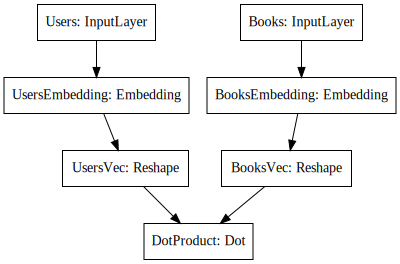

In [60]:
plot_model(matMulModel, to_file='matMulModel.png', show_shapes=True)
SVG(model_to_dot(matMulModel).create(prog='dot', format='svg'))

In [ ]:
callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=3), 
             keras.callbacks.ModelCheckpoint('matMulModelWeights.h5', save_best_only=True)]

trainingHistory = matMulModel.fit([trainDataFrame.userIDX, 
                                   trainDataFrame.bookIDX], 
                                  trainDataFrame.impressionRating,
                                  validation_split=.1,  
                                  callbacks=callbacks,
                                  batch_size=MM_BATCH_SIZE,
                                  epochs=MM_TRAIN_EPOCHS, 
                                  verbose=TRAIN_VERBOSE)

In [ ]:
pd.Series(trainingHistory.history)

In [ ]:
pd.Series(trainingHistory.history['loss']).plot(logy=True, label="Train Loss")
pd.Series(trainingHistory.history['val_loss']).plot(logy=True, label="Val Loss")
plt.legend(loc='upper right')
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [ ]:
# Make some preditions
matMulRatingsPredictions = matMulModel.predict([testDataFrame.userIDX, testDataFrame.bookIDX])
matMulRatingsPredictions = np.rint(matMulRatingsPredictions)

In [ ]:
displaySideBySide(pd.DataFrame(matMulRatingsPredictions).head(100), pd.DataFrame(actualImpressionRatings.head(100)))

In [ ]:
# How did we do?
print("MAE {0:2.2f}".format(mean_absolute_error(actualImpressionRatings, matMulRatingsPredictions)))
print("RMSE {0:2.2f}".format(sqrt(mean_squared_error(actualImpressionRatings, matMulRatingsPredictions))))

In [ ]:
# Retrieve the learnt embeddings
booksLearntEmbeddings = matMulModel.get_layer(name='BooksEmbedding').get_weights()[0]
usersLearntEmbeddings = matMulModel.get_layer(name='UsersEmbedding').get_weights()[0]

In [ ]:
displaySideBySide(pd.DataFrame(usersLearntEmbeddings).head(), pd.DataFrame(usersLearntEmbeddings).describe())

In [ ]:
displaySideBySide(pd.DataFrame(booksLearntEmbeddings).head(), pd.DataFrame(booksLearntEmbeddings).describe())

#### ----------Model 2: Neural Net Implementation (adding depth)-------------

In [61]:
usersInput = keras.layers.Input(shape=[1],name='Users')
booksInput = keras.layers.Input(shape=[1], name='Books')

bias = 1

# check if we're enforcing non-negative Matrix Factorization
# if so, include the constraint
if NNMF:
    usersEmbedding = keras.layers.Embedding(input_dim=numOfUsers + 1, 
                                            output_dim=MM_LATENT_FACTORS,
                                            embeddings_regularizer=l2(1e-4),
                                            name='UsersEmbedding',
                                           embeddings_constraint=non_neg())(usersInput)
    booksEmbedding = keras.layers.Embedding(input_dim=numOfBooks + 1, 
                                            output_dim=MM_LATENT_FACTORS,
                                            embeddings_regularizer=l2(1e-4),
                                            name='BooksEmbedding', 
                                             embeddings_constraint=non_neg())(booksInput)
else:
    usersEmbedding = keras.layers.Embedding(input_dim=numOfUsers + 1, 
                                            output_dim=MM_LATENT_FACTORS,
                                            embeddings_regularizer=l2(1e-4),
                                            name='UsersEmbedding')(usersInput)
    booksEmbedding = keras.layers.Embedding(input_dim=numOfBooks + 1, 
                                            output_dim=MM_LATENT_FACTORS, 
                                            embeddings_regularizer=l2(1e-4),
                                            name='BooksEmbedding')(booksInput)


userBias = keras.layers.Embedding(input_dim=numOfUsers + 1, 
                                  output_dim=bias,
                                  input_length=1,
                                  name="userBias")(usersInput)
bookBias = keras.layers.Embedding(input_dim=numOfBooks + 1, 
                                  output_dim=bias,
                                  input_length=1,
                                  name="bookBias")(booksInput)

userBias = keras.layers.Flatten()(userBias)
bookBias = keras.layers.Flatten()(bookBias)

usersVec = keras.layers.Flatten()(usersEmbedding)
booksVec = keras.layers.Flatten()(booksEmbedding)

dotProd = keras.layers.dot([usersVec, booksVec], axes=1, normalize=True, name='DotProduct')



concatVecs = keras.layers.Concatenate()([dotProd, userBias, bookBias])

d1 = keras.layers.Dense(128, activation='relu')(concatVecs)
d1_drop = keras.layers.Dropout(0.2, name='Dropout')(d1)

d2 = keras.layers.Dense(1)(d1)
d2_drop = keras.layers.Dropout(0.2, name='Dropout')(d2)

neuralNetModel = keras.Model([usersInput, booksInput], d2)


if SGD_OPTIMIZER:
    optimizer = SGD(SGD_lr, SGD_momentum, SGD_decay, SGD_nesterov)
else:
    optimizer = Adam(Adam_lr, Adam_beta_1, Adam_beta_2, Adam_epsilon, Adam_decay, Adam_amsgrad)

neuralNetModel.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'acc'])

neuralNetModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Users (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
Books (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
UsersEmbedding (Embedding)      (None, 1, 5)         86265       Users[0][0]                      
__________________________________________________________________________________________________
BooksEmbedding (Embedding)      (None, 1, 5)         105645      Books[0][0]                      
__________________________________________________________________________________________________
flatten_3 

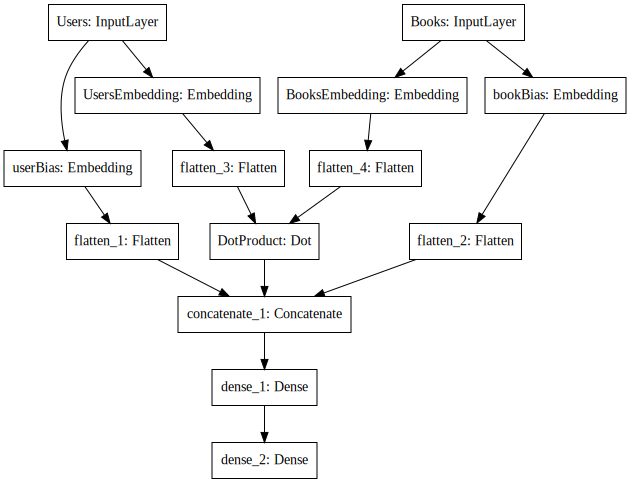

In [62]:
plot_model(neuralNetModel, to_file='neuralNetModel.png', show_shapes=True)
SVG(model_to_dot(neuralNetModel).create(prog='dot', format='svg'))

In [ ]:
callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=3), 
             keras.callbacks.ModelCheckpoint('neuralNetModelWeights.h5', save_best_only=True)]

trainingHistory = neuralNetModel.fit([trainDataFrame.userIDX, trainDataFrame.bookIDX], 
                                     trainDataFrame.impressionRating, 
                                     validation_split=.1, 
                                     callbacks=callbacks,
                                     batch_size=NN_BATCH_SIZE,
                                     epochs=NN_TRAIN_EPOCHS, 
                                     verbose=TRAIN_VERBOSE)

In [ ]:
pd.Series(trainingHistory.history)

In [ ]:
pd.Series(trainingHistory.history['loss']).plot(logy=True, label="Train Loss")
pd.Series(trainingHistory.history['val_loss']).plot(logy=True, label="Val Loss")
plt.legend(loc='upper right')
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [ ]:
# Make some preditions
neuralNetRatingsPredictions = neuralNetModel.predict([testDataFrame.userIDX, 
                                                      testDataFrame.bookIDX])
neuralNetRatingsPredictions = np.rint(neuralNetRatingsPredictions)

In [ ]:
displaySideBySide(pd.DataFrame(neuralNetRatingsPredictions).head(30), 
                  pd.DataFrame(actualImpressionRatings).head(30))

#### ----------Model 3: Neural Net Implementation (adding Bias and 2 features: Author & YearOfPublication)-------------

In [63]:
usersInput = keras.layers.Input(shape=[1],name='Users')
booksInput = keras.layers.Input(shape=[1], name='Books')
authorsInput = keras.layers.Input(shape=[1], name='Authors')
yearOfPubInput = keras.layers.Input(shape=[1], name='YearOfPub')

bias = 1

# check if we're enforcing non-negative Matrix Factorization
# if so, include the constraint
if NNMF:
    usersEmbedding = keras.layers.Embedding(input_dim=numOfUsers + 1, 
                                            output_dim=MM_LATENT_FACTORS,
                                            embeddings_regularizer=l2(1e-4),
                                            name='UsersEmbedding',
                                            embeddings_constraint=non_neg())(usersInput)
    booksEmbedding = keras.layers.Embedding(input_dim=numOfBooks + 1, 
                                            output_dim=MM_LATENT_FACTORS, 
                                            embeddings_regularizer=l2(1e-4),
                                            name='BooksEmbedding', 
                                            embeddings_constraint=non_neg())(booksInput)
else:
    usersEmbedding = keras.layers.Embedding(input_dim=numOfUsers + 1, 
                                            output_dim=MM_LATENT_FACTORS, 
                                            embeddings_regularizer=l2(1e-4),
                                            name='UsersEmbedding')(usersInput)
    booksEmbedding = keras.layers.Embedding(input_dim=numOfBooks + 1, 
                                            output_dim=MM_LATENT_FACTORS, 
                                            embeddings_regularizer=l2(1e-4),
                                            name='BooksEmbedding')(booksInput)


userBias = keras.layers.Embedding(input_dim=numOfUsers + 1, 
                                  output_dim=bias,
                                  input_length=1,
                                  name="userBias")(usersInput)
bookBias = keras.layers.Embedding(input_dim=numOfBooks + 1, 
                                  output_dim=bias,
                                  input_length=1,
                                  name="bookBias")(booksInput)

userBias = keras.layers.Flatten()(userBias)
bookBias = keras.layers.Flatten()(bookBias)

usersVec = keras.layers.Flatten()(usersEmbedding)
booksVec = keras.layers.Flatten()(booksEmbedding)

dotProd = keras.layers.dot([usersVec, booksVec], axes=1, normalize=True, name='DotProduct')



concatVecs = keras.layers.Concatenate()([dotProd, userBias, bookBias, authorsInput, yearOfPubInput])

d1 = keras.layers.Dense(128, activation='relu')(concatVecs)
d1_drop = keras.layers.Dropout(0.2, name='Dropout')(d1)

d2 = keras.layers.Dense(1)(d1)
d2_drop = keras.layers.Dropout(0.2, name='Dropout')(d2)

neuralNetModel = keras.Model(inputs=[usersInput, booksInput, authorsInput, yearOfPubInput], outputs=d2)


if SGD_OPTIMIZER:
    optimizer = SGD(SGD_lr, SGD_momentum, SGD_decay, SGD_nesterov)
else:
    optimizer = Adam(Adam_lr, Adam_beta_1, Adam_beta_2, Adam_epsilon, Adam_decay, Adam_amsgrad)

neuralNetModel.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'acc'])

neuralNetModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Users (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
Books (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
UsersEmbedding (Embedding)      (None, 1, 5)         86265       Users[0][0]                      
__________________________________________________________________________________________________
BooksEmbedding (Embedding)      (None, 1, 5)         105645      Books[0][0]                      
__________________________________________________________________________________________________
flatten_7 

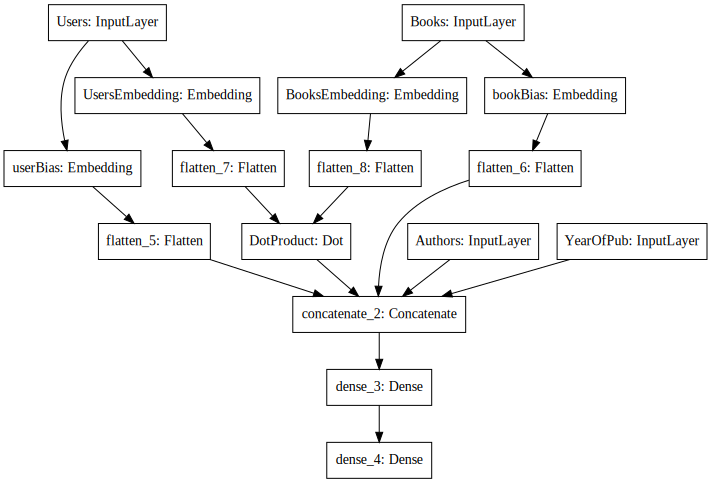

In [64]:
plot_model(neuralNetModel, to_file='neuralNetModel.png', show_shapes=True)
SVG(model_to_dot(neuralNetModel).create(prog='dot', format='svg'))

In [ ]:
callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=3), 
             keras.callbacks.ModelCheckpoint('neuralNetModelWeights.h5', save_best_only=True)]

trainingHistory = neuralNetModel.fit([trainDataFrame.userIDX, 
                                      trainDataFrame.bookIDX, 
                                      trainDataFrame.authorIDX, 
                                      trainDataFrame.yearOfPublication], 
                                     trainDataFrame.impressionRating, 
                                     validation_split=.1, 
                                     callbacks=callbacks,
                                     batch_size=NN_BATCH_SIZE,
                                     epochs=NN_TRAIN_EPOCHS, 
                                     verbose=TRAIN_VERBOSE)

In [ ]:
pd.Series(trainingHistory.history)

In [ ]:
pd.Series(trainingHistory.history['loss']).plot(logy=True, label="Train Loss")
pd.Series(trainingHistory.history['val_loss']).plot(logy=True, label="Val Loss")
plt.legend(loc='upper right')
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [ ]:
# Make some preditions
neuralNetRatingsPredictions = neuralNetModel.predict([testDataFrame.userIDX, 
                                                      testDataFrame.bookIDX,
                                                     trainDataFrame.yearOfPublication, 
                                     trainDataFrame.impressionRating])
neuralNetRatingsPredictions = np.rint(neuralNetRatingsPredictions)

In [ ]:
displaySideBySide(pd.DataFrame(neuralNetRatingsPredictions).head(30), 
                  pd.DataFrame(actualImpressionRatings).head(30))

#### ----------Model 4: Neural Net Implementation (adding more depth)-------------

In [61]:
# Neural Net Implementation


usersInput = keras.layers.Input(shape=[1], name='Users')
usersEmbedding = keras.layers.Embedding(numOfUsers + 1, 
                                        NN_USER_LATENT_FACTORS, 
                                        name='UsesEmbedding')(usersInput)
usersVec = keras.layers.Flatten(name='FlattenUsers')(usersEmbedding)
usersVec = keras.layers.Dropout(0.2)(usersVec)


booksInput = keras.layers.Input(shape=[1], name='Books')
booksEmbedding = keras.layers.Embedding(numOfBooks + 1, 
                                         NN_MOVIE_LATENT_FACTORS,
                                         name='BooksEmbedding')(booksInput)
booksVec = keras.layers.Flatten(name='FlattenBooks')(booksEmbedding)
booksVec = keras.layers.Dropout(0.2)(booksVec)


concatLayer = keras.layers.concatenate([booksVec, usersVec], axis=1, name='ConcatLayer')
concatDropout = keras.layers.Dropout(0.2)(concatLayer)

denseLayer_1 = keras.layers.Dense(64, activation='relu', name='FullyConnected-0')(concatLayer)
dropoutLayer_1 = keras.layers.Dropout(0.2, name='Dropout')(denseLayer_1)

denseLayer_2 = keras.layers.Dense(32, activation='relu', name='FullyConnected-1')(concatLayer)
dropoutLayer_2 = keras.layers.Dropout(0.2, name='Dropout')(denseLayer_2)

denseLayer_3 = keras.layers.Dense(16, activation='relu', name='FullyConnected-2')(concatLayer)
dropoutLayer_3 = keras.layers.Dropout(0.2, name='Dropout-1')(denseLayer_3)

denseLayer_4 = keras.layers.Dense(8, activation='relu', name='FullyConnected-3')(dropoutLayer_3)
dropoutLayer_4 = keras.layers.Dropout(0.2, name='Dropout-2')(denseLayer_4)

result = keras.layers.Dense(1, activation='relu', name='Activation')(dropoutLayer_4)

if SGD_OPTIMIZER:
    optimizer = SGD(SGD_lr, SGD_momentum, SGD_decay, SGD_nesterov)
else:
    optimizer = Adam(Adam_lr, Adam_beta_1, Adam_beta_2, Adam_epsilon, Adam_decay, Adam_amsgrad)

neuralNetModel = keras.Model([usersInput, booksInput], result)
neuralNetModel.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'acc'])

neuralNetModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Books (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
Users (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
BooksEmbedding (Embedding)      (None, 1, 150)       3169350     Books[0][0]                      
__________________________________________________________________________________________________
UsesEmbedding (Embedding)       (None, 1, 150)       2587950     Users[0][0]                      
__________________________________________________________________________________________________
FlattenBoo

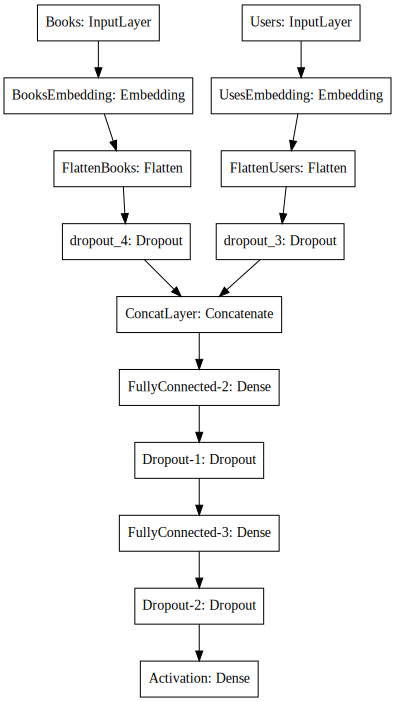

In [62]:
plot_model(neuralNetModel, to_file='neuralNetModel.png', show_shapes=True)
SVG(model_to_dot(neuralNetModel).create(prog='dot', format='svg'))

In [63]:
trainDataFrame.head()

,userId,bookISBN,impressionRating,author,yearOfPublication,authorIDX,bookIDX,userIDX
30466,49900,1551667290,2,Candace Camp,2003,1229,11340,4393
14082,80908,8440673582,3,John Varley,1999,2218,2707,1610
35813,116703,031225220X,5,Susan Sussman,2000,10749,15426,15681
34785,75339,3442726875,3,Patrick McGrath,2000,8947,14589,10459
6558,146175,042513525X,3,Dean R. Koontz,1992,682,745,4860


In [64]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=20,
                                           verbose=0, 
                                           mode='auto'), 
             keras.callbacks.ModelCheckpoint('neuralNetModelWeights.h5', save_best_only=True)]

trainingHistory = neuralNetModel.fit([trainDataFrame.userIDX, trainDataFrame.bookIDX], 
                                     trainDataFrame.impressionRating, 
                                     validation_split=.2, 
                                     callbacks=callbacks,
                                     batch_size=NN_BATCH_SIZE,
                                     epochs=NN_TRAIN_EPOCHS, 
                                     verbose=TRAIN_VERBOSE)

# trainingHistory = neuralNetModel.fit([trainDataFrame.userIDX, trainDataFrame.bookIDX], 
#                                      trainDataFrame.impressionRating, 
#                                      batch_size=NN_BATCH_SIZE,
#                                      epochs=NN_TRAIN_EPOCHS, 
#                                      verbose=TRAIN_VERBOSE)

Train on 26270 samples, validate on 6568 samples
Epoch 1/50
26270/26270 [==============================] - 10s 368us/step - loss: 3.5537 - mean_squared_error: 3.5537 - acc: 0.2088 - val_loss: 1.8046 - val_mean_squared_error: 1.8046 - val_acc: 0.2891
Epoch 2/50
26270/26270 [==============================] - 9s 331us/step - loss: 1.6649 - mean_squared_error: 1.6649 - acc: 0.3146 - val_loss: 1.7890 - val_mean_squared_error: 1.7890 - val_acc: 0.2942
Epoch 3/50
26270/26270 [==============================] - 8s 322us/step - loss: 1.1448 - mean_squared_error: 1.1448 - acc: 0.3918 - val_loss: 1.8128 - val_mean_squared_error: 1.8128 - val_acc: 0.2795
Epoch 4/50
26270/26270 [==============================] - 9s 339us/step - loss: 0.8898 - mean_squared_error: 0.8898 - acc: 0.4488 - val_loss: 1.8490 - val_mean_squared_error: 1.8490 - val_acc: 0.2823
Epoch 5/50
26270/26270 [==============================] - 8s 322us/step - loss: 0.7514 - mean_squared_error: 0.7514 - acc: 0.4967 - val_loss: 1.8735 -

In [65]:
pd.Series(trainingHistory.history)

val_loss                  [1.8045828548621898, 1.7890146231680346, 1.812...
val_mean_squared_error    [1.8045828548621898, 1.7890146231680346, 1.812...
val_acc                   [0.2891291107315384, 0.2941534711041201, 0.279...
loss                      [3.553743739612755, 1.6648603642808197, 1.1447...
mean_squared_error        [3.553743739612755, 1.6648603642808197, 1.1447...
acc                       [0.20879330035819496, 0.3146174353681048, 0.39...
dtype: object

Text(0,0.5,'Training Error')

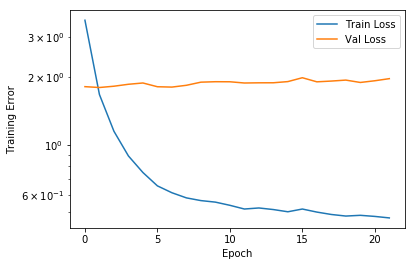

In [66]:
pd.Series(trainingHistory.history['loss']).plot(logy=True, label="Train Loss")
pd.Series(trainingHistory.history['val_loss']).plot(logy=True, label="Val Loss")
plt.legend(loc='upper right')
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [67]:
# Make some preditions
neuralNetRatingsPredictions = neuralNetModel.predict([testDataFrame.userIDX, 
                                                      testDataFrame.bookIDX])
neuralNetRatingsPredictions = np.rint(neuralNetRatingsPredictions)

In [68]:
displaySideBySide(pd.DataFrame(neuralNetRatingsPredictions).head(20), 
                  pd.DataFrame(actualImpressionRatings).head(20))

,0
0,3.0
1,2.0
2,3.0
3,2.0
4,4.0
5,5.0
6,3.0
7,3.0
8,3.0
9,2.0


In [ ]:
# How did we do?
print("MAE {0:2.2f}".format(mean_absolute_error(actualImpressionRatings, neuralNetRatingsPredictions)))
print("RMSE {0:2.2f}".format(sqrt(mean_squared_error(actualImpressionRatings, neuralNetRatingsPredictions))))

#### ---------END OF NOTEBOOK--------------